# CSV Analysis: Country

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 400 # Avoid "..." in large strings
pd.options.display.max_rows = 110     # Avoid "..." in the table representation of lengthy dataframes

## What do people do to normalize country names?

Short answer: mostly, they don't.
They instead seem to enforce a list of names or codes (e.g. ISO-3166)
when collecting their inputs.
There are regex and Levenshtein distance \[fuzzy] approaches,
but most stuff found only works like a key-value storage
with a very limited querying system, if any.
SciELO's [wayta](http://wayta.scielo.org) API
and the Python [`countrynames` library](https://pypi.org/project/countrynames/)
have the best results when it comes to fix typos.

Most code in this section of the notebook was run in an external isolated REPL (e.g. a Python virtualenv) with the results reported here.

### Exact match

There are several packages out there to convert between distinct country name/code formats,
but that mapping (and reverse mapping) should be exact.
For example, there's the
[Skye Shaw's `normalize_country` Ruby gem](https://github.com/sshaw/normalize_country),
but that's actually just a bunch of data for strict mapping,
its table of country names in English and their codes in several formats are written in
[this YAML file](https://github.com/sshaw/normalize_country/blob/master/lib/normalize_country/countries/en.yml).
It tries to look for the input country in every column, and maps it to the desired column:

```ruby
irb(main):001:0> require "normalize_country"
=> true
irb(main):002:0> NormalizeCountry("Brazil")
=> "Brazil"
irb(main):003:0> NormalizeCountry("Brasil")
=> nil
irb(main):004:0> NormalizeCountry("BrA")
=> "Brazil"
irb(main):005:0> NormalizeCountry("America")
=> "United States"
irb(main):006:0> NormalizeCountry("United State")
=> nil
irb(main):007:0> NormalizeCountry("Brazil", :to => "ioc")
=> "BRA"
irb(main):008:0> NormalizeCountry("Brazil", :to => "alpha2")
=> "BR"
irb(main):009:0> NormalizeCountry("Brazil", :to => "fifa")
=> "BRA"
irb(main):010:0> NormalizeCountry("Brazil", :to => "official")
=> "Federative Republic of Brazil"
```

That's only a list of names in English.
Perhaps a web scrapping approach to get the country information from some Wikipedia links
would yield a more complete table of names and codes,
perhaps including several alternative names.
Nevertheless, that's still an exact find-and-replace approach.

A project with country names mappings that's worth citing is the
[Saša Stamenković's country-list for PHP](https://github.com/umpirsky/country-list),
which has code-name mapping tables for
[several different languages](https://github.com/umpirsky/country-list/tree/master/data).
Niels Lemmens wrote a `country_list` Python package
([PyPI](https://pypi.org/project/country-list/),
 [GitHub](https://github.com/bulv1ne/country_list))
to access the information from that country list:

```python
>>> import country_list
>>> c = country_list.countries_for_language("pt_BR")
>>> type(c)
<class 'list'>
>>> len(c)
255
>>> c[:4]
[('AF', 'Afeganistão'), ('ZA', 'África do Sul'), ('AL', 'Albânia'), ('DE', 'Alemanha')]
```

Some other packages/libraries:

- [Carmen for Ruby](https://github.com/carmen-ruby/carmen),
[Josh Robinson's `countries` for Ruby](https://github.com/hexorx/countries),
and Christian Theune's `pycountry` for Python
([PyPI](https://pypi.org/project/pycountry/),
 [BitBucket](https://bitbucket.org/flyingcircus/pycountry)),
which gives us access to the
[Debian iso-codes](https://salsa.debian.org/iso-codes-team/iso-codes)' lists;

- [`i18n_data` for Ruby](https://github.com/grosser/i18n_data),
which also provides translations through Debian iso-codes;

- `pycountry-convert` extension for `pycountry`
([PyPI](https://pypi.org/project/pycountry-convert/),
 [GitHub](https://github.com/TuneLab/pycountry-convert))
have some extra country data allegedly from Wikipedia
[in its Python code](https://github.com/TuneLab/pycountry-convert/blob/master/pycountry_convert/country_wikipedia.py);

- [`model_un` for Ruby](https://github.com/uhhuhyeah/model_un),
which have its own country data
[in its Ruby code](https://github.com/uhhuhyeah/model_un/blob/master/lib/model_un/data.rb);

- Porimol Chandro's `countryinfo` for Python
([PyPI](https://pypi.org/project/countryinfo/),
 [GitHub](https://github.com/porimol/countryinfo)),
a country information dataset as a Python dictionary,
including border countries and GeoJSON polygon shape;

- Robert Gieseke's `shortcountrynames` for Python and JavaScript
([PyPI](https://pypi.org/project/shortcountrynames/),
 [GitHub](https://github.com/rgieseke/shortcountrynames)),
which converts country codes to names using
[this CSV table](https://github.com/rgieseke/shortcountrynames/blob/master/shortcountrynames.csv).
It's based on the Data Packaged Core Datasets' `country-codes`
([GitHub](https://github.com/datasets/country-codes)),
though the author tells he has changed the short names to his taste;

- Renaud Canarduck's `pays` for Python
([PyPI](https://pypi.org/project/pays/),
 [GitLab](https://gitlab.com/canarduck/pays)),
which gives access to part of the countries dataset of the Mohammed Le Doze's
[countries project for PHP/JavaScript](https://github.com/mledoze/countries);

- Geoffrey Bauduin's `isocountrycode` for Python
([PyPI](https://pypi.org/project/isocountrycode/),
 [GitHub](https://github.com/geoffreybauduin/python-isocountrycode))
has a single Alpha2 enum class mapping the ISO-3166 codes to the country names
using `_` (undescore) instead of spaces;

- Mike Spindel's `iso3166` package for Python
([PyPI](https://pypi.org/project/iso3166/),
 [GitHub](https://github.com/deactivated/python-iso3166)),
hardcoded with mappings of names and codes.

A somewhat related information is that the unicode country flag \[emoji] code points
can be found directly from the ISO-3166 2-character country codes,
as described by Matthew Schinckel in
[his 2015-10-29 blog post](http://schinckel.net/2015/10/29/unicode-flags-in-python/).
That approach is used by converters like
[`emoji-country-flag`for Python](https://pypi.org/project/emoji-country-flag/),
but not by the already shown `normalize_country` for Ruby.
Looking for unicode country flags converters we can find packages/libraries
that might include exact-match country name to country code converters.

### Regex-based solutions

The [Unicode's CLDR project](cldr.unicode.org) has an
[XML with lots of information for managing locales and performing
 system internationalization](http://unicode.org/repos/cldr/trunk/common/supplemental/supplementalData.xml).
Vincent Arel-Bundock's `countrycode` library for R
([CRAN](https://cran.r-project.org/package=countrycode),
 [GitHub](https://github.com/vincentarelbundock/countrycode))
uses that CLDR data to standardize/normalize a country name:

```r
> library(countrycode)
> countrycode("brazil", "country.name", "iso2c")
[1] "BR"
> countrycode("brazzil", "country.name", "iso2c")
[1] NA
Warning message:
In countrycode("brazzil", "country.name", "iso2c") :
  Some values were not matched unambiguously: brazzil

> countrycode("brasil", "country.name", "iso2c")
[1] NA
Warning message:
In countrycode("brasil", "country.name", "iso2c") :
  Some values were not matched unambiguously: brasil

> countrycode("unites states", "country.name", "iso2c")
[1] NA
Warning message:
In countrycode("unites states", "country.name", "iso2c") :
  Some values were not matched unambiguously: unites states

> countrycode("united states", "country.name", "iso2c")
[1] "US"
> countrycode("unites states america", "country.name", "iso2c")
[1] NA
Warning message:
In countrycode("unites states america", "country.name", "iso2c") :
  Some values were not matched unambiguously: unites states america

> countrycode("united states amerika", "country.name", "iso2c")
[1] "US"
```

It's not a *fuzzy* approach based on some edit distance,
the Levenshtein distance of the last $2$ entries
to the correct name should be the same,
yet the results are different.
When running the above code, we're actually looking for
an exact case insensitive match for `brazil`
and `united.?states\b(?!.*islands)|\bu\.?s\.?a\.?\b|^\s*u\.?s\.?\b(?!.*islands)`,
[as `data_static.csv` tells us](https://github.com/vincentarelbundock/countrycode/blob/master/dictionary/data_static.csv).

Konstantin Stadler's `country_converter`package for Python
([PyPI](https://pypi.org/project/country_converter/),
 [GitHub](https://github.com/konstantinstadler/country_converter))
has a similar strategy:

```python
>>> import country_converter as coco
>>> coco.convert("brazil")
'BRA'
>>> coco.convert("brazil", to="ISO2")
'BR'
>>> coco.convert("brazzil", to="ISO2")
WARNING:root:brazzil not found in regex
'not found'
>>> coco.convert("brasil", to="ISO2")
WARNING:root:brasil not found in regex
'not found'
>>> coco.convert("brazill", to="ISO2")
'BR'
>>> coco.convert("unites states", to="ISO2")
WARNING:root:unites states not found in regex
'not found'
>>> coco.convert("united states", to="ISO2")
'US'
>>> coco.convert("unites states america", to="ISO2")
WARNING:root:unites states america not found in regex
'not found'
>>> coco.convert("united states amerika", to="ISO2")
'US'
```

But the actual regexes being used [aren't the same](),
e.g. `^(?!.*islands).*united.?states|^u\.?s\.?a\.?$|^u\.?s\.?$`
is the new regex for the *United States*.

That regex-based approach is slightly better than an exact match, but creating such regex tables manually might be time-consuming and might not be enough to cover a single character typo.

### Fuzzy / Levenshtein matching

The Michael Rans' HDX Python Country Library
([PyPI](https://pypi.org/project/hdx-python-country/),
 [GitHub](https://github.com/OCHA-DAP/hdx-python-country))
queries the [UNStats M49 website](https://unstats.un.org/unsd/methodology/m49/overview/)
and the [World Bank JSON API](http://api.worldbank.org/countries?format=json&per_page=50).
it's part of the [Humanitarian Data Exchange](https://data.humdata.org/) project.
That library performs exact, regex and fuzzy matching when queried with
the `hdx.location.country.Country.get_iso3_country_code_fuzzy` method.
However, that library isn't a promising route:
there are obviously incorrect results (like the `ARE` below)
and a fragile system that breaks on some inputs
that would require a pre-sanitization to be used,
and it's still way too strict
(might not find an unambiguous country with a single character typo):

```python
>>> from hdx.location.country import Country
>>> Country.get_iso3_country_code_fuzzy("brazil")
('BRA', True)
>>> Country.get_iso3_country_code_fuzzy("Brazill")
('BRA', False)
>>> Country.get_iso3_country_code_fuzzy("brazzil")
(None, False)
>>> Country.get_iso3_country_code_fuzzy("brasil")
(None, False)
>>> Country.get_iso3_country_code_fuzzy("Unites states")
(None, False)
>>> Country.get_iso3_country_code_fuzzy("United states ameirka")
('USA', False)
>>> Country.get_iso3_country_code_fuzzy("Usa")
('USA', True)
>>> Country.get_iso3_country_code_fuzzy("U.s.a")
('ARE', False)
>>> Country.get_iso3_country_code_fuzzy("U.s.a.")
Traceback (most recent call last):
  ...
ValueError: list.remove(x): x not in list
```

The aleph data search's `countrynames` package for Python
([PyPI](https://pypi.org/project/countrynames/),
 [GitHub](https://github.com/alephdata/countrynames))
has a both an exact-match and a fuzzy-match converter
from country names to country codes based in
[this YAML dataset](https://github.com/alephdata/countrynames/blob/master/countrynames/data.yaml).

```python
>>> import countrynames
>>> countrynames.to_code("bazill", fuzzy=True)
'BR'
>>> countrynames.to_code("brassill", fuzzy=True)
'BR'
>>> countrynames.to_code("unites stated", fuzzy=True)
'US'
>>> countrynames.to_code("u.s.a.", fuzzy=True) # returns None
```

The [wayta](http://wayta.scielo.org/) service provided by SciELO
([source](https://github.com/scieloorg/wayta)) uses the
[Elasticsearch Fuzzy Query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-fuzzy-query.html)
to match the input with some entry in its
[normalized_country.csv](https://github.com/scieloorg/wayta/blob/master/processing/normalized_country.csv). For example:

In [2]:
from urllib.request import urlopen
from urllib.parse import urlencode
import json

In [3]:
def wayta_query(name):
    query = urlencode({"q": name.upper()})
    response = urlopen("http://wayta.scielo.org/api/v1/country?" + query)
    return json.loads(response.read())

In [4]:
wayta_query("bazill")

{'head': {'match': 'by_similarity'},
 'choices': [{'country': 'Brazil',
   'score': 6.3303013,
   'iso3166': 'BR',
   'value': 'Brazil'}]}

In [5]:
wayta_query("unites stated")

{'head': {'match': 'by_similarity'},
 'choices': [{'country': 'United States',
   'score': 6.260096,
   'iso3166': 'US',
   'value': 'United States'}]}

In [6]:
wayta_query("u.s.a.")

{'head': {'match': 'exact'},
 'choices': [{'score': 6.3303013, 'iso3166': 'US', 'value': 'United States'}]}

So far, the SciELO's `wayta` service and
the aleph data search's `countrynames` package
are the best country normalization/sanitization tools evaluated.

## Loading CSV data from Clea

We will analyze the content of
[this CSV file](https://drive.google.com/file/d/1XmBh6YlfPkB5WfYSolAMP1EA5e02jHQO/view?usp=sharing)
created [here](https://github.com/scieloorg/normalizations-experiments/blob/master/experiments_2018-06-04.ipynb)
with [SciELO's Clea](https://github.com/scieloorg/clea)
from a selection of SciELO's articles corpora (XML documents).

In [7]:
dataset = pd.read_csv("inner_join_2018-06-04.csv",
                      dtype=str,
                      keep_default_na=False) \
            .drop_duplicates()

In [8]:
dataset.describe()[[k for k in dataset.columns if k.startswith("addr")]]

,addr_city,addr_country,addr_country_code,addr_postal_code,addr_state
count,89451,89451,89451,89451,89451
unique,2729,267,125,426,672
top,,Brazil,BR,,
freq,9529,48429,56596,87918,20906


The address information is incomplete in most entries:
87918 documents don't have a postal code.
But for the remaining columns
it seems that most rows have some information regarding the address.
Data is unbalanced and has unmatched fields:

- Brazil appears far more often than other countries;
- Brazil and BR don't count the same.

There are $266$ distinct country names and $124$ distinct country codes in this dataset
($+1$ of each if we count the empty entries):

In [9]:
print(", ".join(dataset["addr_country"].unique()))

Brazil, Portugal, Brasil, Uruguay, Spain, Italy, Argentina, Venezuela, Germany, USA, United Kingdom, República Argentina, France, England, Itália, França, Dinamarca, Colombia, Switzerland, Canada, Pakistan, Cuba, México, Mexico, Costa Rica, China, Saudi Arabia, BraZil, Greece, Espanha, , Alemanha, Estados Unidos, Australia, Malaysia, Jamaica, India, United States, Unites States, Paraguay, España, Chile, Sweden, Panama, UAE, Egypt, Qatar, Nigeria, Sri Lanka, Belgium, Denmark, U.K, Turkey, Iran, Russia, Italia, Poland, Dominican Republic, Índia, Austrália, Tailândia, People's Republic of China, Tunisia, United Arab Emirates, Azerbaijan, Romania, Bulgaria, Thailand, Japan, PR China, Republic of Korea, Slovakia, Taiwan, Algeria, Korea, Kingdom of Bahrain, Austria, BR, Netherlands, South Korea, Bangladesh, Serbia, Hong Kong, South Africa, Peru, Canadá, Colômbia, Equador, Slovenia, China., The Netherlands, Brazil., UK, Bolivia, BO, Ireland, sofialopezmdp@gmail.com, EUA, Guiana, Portuga, Braz

In [10]:
len(dataset["addr_country"].unique())

267

In [11]:
dataset["addr_country_code"].unique()

array(['BR', 'PT', '', 'UY', 'ES', 'IT', 'AR', 'VE', 'DE', 'US', 'GB',
       'FR', 'DK', 'CO', 'CH', 'CA', 'PK', 'CU', 'MX', 'CR', 'CN', 'SA',
       'GR', 'AT', 'MY', 'JM', 'IN', 'SE', 'AU', 'CL', 'PA', 'AE', 'EG',
       'QA', 'NG', 'LK', 'BE', 'TR', 'IR', 'RU', 'PL', 'TN', 'RO', 'BG',
       'TH', 'JP', 'KP', 'SK', 'TW', 'DZ', 'KR', 'NL', 'BD', 'RS', 'HK',
       'ZA', 'PE', 'EC', 'SI', 'BO', 'IE', 'GY', 'BR; BR', 'CY', 'HU',
       'IQ', 'PY', 'UK', 'HR', 'UA', 'FI', 'IL', 'MD', 'NI', 'NO', 'JO',
       'NZ', 'GD', 'SW', 'BV', 'AG', 'UG', 'CZ', 'CS', 'HN', 'BJ', 'MG',
       'ME', 'TA', 'TZ', 'ZM', 'MZ', 'AO', 'LU', 'PR', 'GH', 'ID', 'BF',
       'PF', 'BM', 'MK', 'EE', 'VN', 'PO', 'SN', 'MU', 'CM', 'MA', 'BA',
       'TK', 'SZ', 'GE', 'OM', 'AL', 'IS', 'LY', 'SD', 'LB', 'KZ', 'SV',
       'GT', 'DO', 'SB', 'LT', 'BY'], dtype=object)

In [12]:
len(dataset["addr_country_code"].unique())

125

But more than 20 thousand rows don't include the country code.
That's quite a lot! Also, this data is clearly unbalanced:

In [13]:
pd.DataFrame(dataset.groupby("addr_country_code")
                    .size()
                    .sort_values(ascending=False)
                    .head(10),
             columns=["count"])

,count
addr_country_code,
BR,56596
,21727
CN,1421
PT,1021
US,989
TR,851
AR,690
ES,599
CO,540


As we've already seen, the top `addr_country_code` ($56596$ `BR` rows)
and top `addr_country` ($48429$ `Brazil` rows) should have had the same value,
but there's a difference,
the country names and codes aren't always filled together,
and there are spurious country names filled in some rows:

In [14]:
dataset.groupby(["addr_country", "addr_country_code"]).size().sort_values(ascending=False).head(30)

addr_country   addr_country_code
Brazil         BR                   38521
Brasil         BR                   17187
Brazil                               9895
Brasil                               5883
                                     2829
China          CN                    1296
Portugal       PT                    1007
Turkey         TR                     844
Argentina      AR                     683
               BR                     638
USA            US                     627
Colombia       CO                     507
Spain          ES                     425
Portugal                              420
Iran           IR                     413
India          IN                     398
Chile          CL                     369
China                                 363
Turkey                                334
Mexico         MX                     310
USA                                   237
México         MX                     223
France         FR                     221
I

There's even some country codes filled as country names:

In [15]:
import re
from unidecode import unidecode

In [16]:
def pre_normalize(name):
    return " ".join(re.sub("[^a-z ]", "", unidecode(name).lower()).split())

In [17]:
data_countries = dataset["addr_country"].apply(pre_normalize)
pd.DataFrame({"count": data_countries[data_countries.apply(len) == 2].value_counts()})

,count
br,154
uk,81
sp,10
am,2
ru,2
be,2
rs,1
us,1
al,1
fr,1


There's no contributor referencing multiple countries at once in this dataset,
there's just one document referencing Brazil twice:

In [18]:
dataset[dataset["addr_country_code"].str.contains(";")]["addr_country_code"].unique()

array(['BR; BR'], dtype=object)

In [19]:
dataset[dataset["addr_country_code"] == "BR; BR"].T

,6353
addr_city,Goiás
addr_country,Brazil; Brazil
addr_country_code,BR; BR
addr_postal_code,
addr_state,GO
aff_email,
aff_id,aff1
aff_text,Federal University at Goiás (UFG) Universidade Federal de Goiás Federal University at Goiás Brazil Goiás GO Brazil
article_doi,10.1590/1982-02592018v21n1p09
article_publisher_id,


Our goal is to find what can be said about the country data of this dataset.

## Graph approach

Looking only to the country name (`addr_country` column)
and to the country code (`addr_country_code` column),
let's see what we can find.
Some possible questions are:

- Is the country pair inconsistent?
- Which inconsistencies are more common?

We won't be able to fill the correct data without some extra information
about the document being analyzed,
unless we use some *prior*,
which would just be a bias towards the unbalanced data we have
(e.g. both `Brasil, CL` and `Chile, BR` would yield `Brasil, BR`,
 because that's the most common pair).
On the other hand,
this *more common* approach for a single country name value
out of its row context
is meaningful:
the name `Chile` is assigned to `CL`,
as `CL` is the code that most `Chile` entries have.
What we can't say is whether the name or the code is wrong
in a given inconsistent row.

So let's find if there are inconsistencies, and whose are they.

In [20]:
pairs = dataset.groupby(["addr_country", "addr_country_code"]).size()
non_empty = pd.DataFrame(
    pairs[(pairs.index.get_level_values("addr_country").str.strip() != "") &
          (pairs.index.get_level_values("addr_country_code").str.strip() != "")],
    columns=["count"]
)
non_empty.head(14)

count
addr_country        addr_country_code       
AL                  AL                     1
Alemanha            DE                    27
Algeria             DZ                    31
Algerie             DZ                     3
Algérie             DZ                     2
Angola              AO                     2
                    AU                     1
                    BR                     1
Antigua and Barbuda AG                     1
Argentin            AR                     2
Argentina           AR                   683
                    BR                    10
Australia           AT                     6
                    AU                    83

These are the top entries, not the worst conflicts,
but there are clear conflicts and multiple languages in there.
Some highlights:

- **AL** is *Albania*, but is that correct in that single entry?
Sometimes we can't trust in neither column values;

- *Algérie* in French, *Argéria* in Portuguese and *Algeria* in English
are a single country with multiple names
due to multiple document languages in this dataset.
At least the country code **DZ** is correct;

- In the ISO 3166-1 alpha-2 code,
*Angola* is **AO**,
*Argentina* is **AR**,
*Australia* is **AU**,
*Austria* is **AT** and
*Brazil* is **BR**.
But there are clearly mixed rows, and they're not just a few
($10$ out of $693$ *Argentina* entries have **BR** as their code).

We can select some country codes to see what's going on:

In [21]:
codes = ["BR", "BV", "CH", "CN", "ES", "FR", "MX", "PT", "TR", "US"]

The country names connected to these codes,
segregated by the number of entries (*count*), is:

In [22]:
df_pairs = pairs.reset_index(name="count")
df_pairs_code = df_pairs[df_pairs["addr_country_code"].isin(codes)]

In [23]:
pd.DataFrame(df_pairs_code.groupby(["addr_country_code", "count"])
                          .apply(lambda grp: sorted(grp["addr_country"])),
             columns=["List of country names"])

List of country names
addr_country_code count                                                                                                                                                           
BR                1      [Angola, Braszil, Brazl, China, Colômbia, FR, Germany, India, Italy, Japan, KSA, Mexico, Moçambique, Nigeria, PA, RS, Slovenia, São Paulo, Venezuela, br]
                  2                                                                                                                       [Brasil., França, Not Normalized, Spain]
                  3                                                                                         [BRASIL, BRAZIL, Chile, Malaysia, People's Republic of China, Uruguay]
                  4                                                                                                                           [Brasill, Portugal, SP, Turkey, USA]
                  5                                                                                                                                      [BraZil, Espanha, México]
                  8                                                                                                                                                          [Bra]
                  10                                                                                                                                                   [Argentina]
                  16                                                                                                                                                     [Brazil.]
                  56                                                                                                                                                          [Br]
                  79                                                                                                                                                          [BR]
                  638                                                                                                                                                           []
                  17187                                                                                                                                                   [Brasil]
                  38521                                                                                                                                                   [Brazil]
BV                1                                                                                                                                                       [Brasil]
                  4                                                                                                                                                       [Brazil]
CH                1                                                                                                                                                        [China]
                  8                                                                                                                                                        [Chile]
                  10                                                                                                                                                       [Suíça]
                  29                                                                                                                                                 [Switzerland]
CN                1                                                                                                                                        [Henan, Taiwan, Urumqi]
                  2                                                                                                                                           [Canada, P. R.China]
                  6                     

The country name has several valid versions we can understand,
but there's too much information in that table:
we don't need to see the names that are always connected to a single code.

The following names are connected to the formerly selected country codes,
but they aren't connected to a single country code:

In [24]:
addr_country_counts = df_pairs_code["addr_country"].value_counts()
mixed_names = addr_country_counts[addr_country_counts > 1].index.tolist()
mixed_names

['',
 'Brazil',
 'Brasil',
 'USA',
 'China',
 'BR',
 'França',
 'Portugal',
 'Spain',
 'Turkey',
 'México',
 'Mexico',
 'Espanha',
 'Chile',
 "People's Republic of China"]

Let's see all the pairs regarding these names and the formerly selected codes:

In [25]:
df_pairs_code[df_pairs_code["addr_country"].isin(mixed_names)] \
     .sort_values(["addr_country_code", "addr_country"], ascending=True) \
     .set_index(["addr_country_code", "addr_country"])

count
addr_country_code addr_country                     
BR                                              638
                  BR                             79
                  Brasil                      17187
                  Brazil                      38521
                  Chile                           3
                  China                           1
                  Espanha                         5
                  França                          2
                  Mexico                          1
                  México                          5
                  People's Republic of China      3
                  Portugal                        4
                  Spain                           2
                  Turkey                          4
                  USA                             4
BV                Brasil                          1
                  Brazil                          4
CH                Chile                           8
                  China                           1
CN                China                        1296
                  People's Republic of China     25
ES                                                2
                  Brasil                          1
                  Brazil                          1
                  Espanha                        45
                  Spain                         425
                  USA                             2
FR                BR                              1
                  França                         53
MX                Mexico                        310
                  México                        223
PT                                                1
                  Brasil                          4
                  Brazil                          6
                  Portugal                     1007
TR                                                1
                  Brazil                          1
                  Turkey                        844
US                                                4
                  Brasil                          1
                  USA                           627

There are many unfilled and inconsistent pairs in this subset of our data.

Nevertheless, the whole data denotes a bipartite graph,
where the two partitions are the *names* and the *codes*,
and each $(name, code)$ pair is an edge.

### Adjacency matrix correlation

This bipartite graph can be depicted as an adjacency matrix.

In [26]:
adj_mat = non_empty.unstack(fill_value=0).xs("count", axis=1, drop_level=True)
adj_mat.shape

(241, 124)

A part of it would be:

In [27]:
adj_mat.iloc[:12, :9]

addr_country_code,AL,DE,DZ,AO,AU,BR,AG,AR,AT
addr_country,,,,,,,,,
AL,1,0,0,0,0,0,0,0,0
Alemanha,0,27,0,0,0,0,0,0,0
Algeria,0,0,31,0,0,0,0,0,0
Algerie,0,0,3,0,0,0,0,0,0
Algérie,0,0,2,0,0,0,0,0,0
Angola,0,0,0,2,1,1,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,1,0,0
Argentin,0,0,0,0,0,0,0,2,0
Argentina,0,0,0,0,0,10,0,683,0


That clearly shows that (not exhaustive):

- There are $27$ connections between the country name *Alemanha* and the code **DE**;
- There are at least $3$ distinct country names connected to the **DZ** code;
- There are at least $3$ distinct codes connected to the name *Angola*;

But that's still a surface-level information.
It's not something easy to compare,
but we can grasp some information using the columns/rows correlations.

We can measure some similarity (correlation) between distinct columns:

In [28]:
br_adj_mat_corr = adj_mat.corrwith(adj_mat["BR"]).sort_values()
br_adj_mat_corr[abs(br_adj_mat_corr) > .01]

addr_country_code
BM    0.912946
BV    0.984703
BR    1.000000
dtype: float64

For connectedness alone
(i.e., using the *this pair either have or doesn't have a connection* without any weight),
we would have:

In [29]:
bin_adj_mat = (adj_mat != 0).applymap(int)
br_bin_adj_mat_corr = bin_adj_mat.corrwith(bin_adj_mat["BR"]).sort_values()
len(br_bin_adj_mat_corr[abs(br_bin_adj_mat_corr) > .01])

123

As only one entry is below that absolute correlation value threshold,
it shouldn't be so small in this connectedness-only scenario. 

In [30]:
br_bin_adj_mat_corr[abs(br_bin_adj_mat_corr) > .15]

addr_country_code
PT    0.154367
MX    0.190914
BV    0.190914
ES    0.265135
BR    1.000000
dtype: float64

Wait there!
Why such a high correlation before and a low correlation afterwards?!
What does that correlation mean anyway?

In [31]:
br_corr_similar_codes = ["PT", "MX", "BV", "ES", "BM", "BR"]
br_like = adj_mat[br_corr_similar_codes]
br_like[br_like.T.apply(sum) > 0].sort_values(by=br_corr_similar_codes)

addr_country_code,PT,MX,BV,ES,BM,BR
addr_country,,,,,,
Angola,0,0,0,0,0,1
Braszil,0,0,0,0,0,1
Brazl,0,0,0,0,0,1
China,0,0,0,0,0,1
Colômbia,0,0,0,0,0,1
FR,0,0,0,0,0,1
Germany,0,0,0,0,0,1
India,0,0,0,0,0,1
Italy,0,0,0,0,0,1


These last 3 rows shows the link between Portugal and Brasil:
there are *Brazil*-**PT**, *Brasil*-**PT** and *Portugal*-**BR** entries,
which makes **BR** and **PT** connectedness similar,
but not enough for a high correlation
due to the several "alternative names" (including typos)
connected to **BR** but not to **PT**,
besides the other two *Portugal* names (the uppercase and `Portugual`).
As it seems, we should not ignore the weights,
at least not the weights relative to the row/column in analysis.

The codes **BM** and **BV** have no other country but Brazil,
though **BM** stands for *Bermuda*
and **BV** stands for *Bouvet Island*,
which makes their entries look like typos:

In [32]:
br_like[br_like[["BM", "BV"]].T.apply(sum) > 0][["BM", "BV", "BR"]]

addr_country_code,BM,BV,BR
addr_country,,,
Brasil,0,1,17187
Brazil,1,4,38521


The same analysis can be performed on the rows
to find the distinct *Brazil* names/aliases/typos:

In [33]:
brazil_adj_mat_corr = adj_mat.T.corrwith(adj_mat.T["Brazil"]).sort_values()
brazil_adj_mat_corr[abs(brazil_adj_mat_corr) > .1]

addr_country
Espanha                       0.102466
People's Republic of China    0.111177
Moçambique                    0.116081
Angola                        0.401014
BR                            0.999920
BRASIL                        1.000000
BRAZIL                        1.000000
br                            1.000000
KSA                           1.000000
Not Normalized                1.000000
Bra                           1.000000
FR                            1.000000
PA                            1.000000
Brasil.                       1.000000
São Paulo                     1.000000
Brasill                       1.000000
Braszil                       1.000000
Brazil.                       1.000000
Brazl                         1.000000
RS                            1.000000
SP                            1.000000
Br                            1.000000
BraZil                        1.000000
Brasil                        1.000000
Brazil                        1.000000
dtype: float

Why *Spain*, *China*, *Mozambique* and *Angola* (the first four entries) are there?
Why the *BR* name is less related to *Brazil* than *Br*?

In [34]:
brazil_similar_condition = (abs(brazil_adj_mat_corr) > .1) & (abs(brazil_adj_mat_corr) < 1 - 1e-7)
brazil_corr_similar_codes = list(brazil_adj_mat_corr[brazil_similar_condition].index)
brazil_like = adj_mat.T[brazil_corr_similar_codes]
brazil_like[brazil_like.T.apply(sum) > 0].T

addr_country_code,AO,AU,BR,FR,ES,CN,MZ
addr_country,,,,,,,
Espanha,0,0,5,0,45,0,0
People's Republic of China,0,0,3,0,0,25,0
Moçambique,0,0,1,0,0,0,8
Angola,2,1,1,0,0,0,0
BR,0,0,79,1,0,0,0


It's still difficult to tell why the *Not Normalized* rows and the *KSA*
have such a high correlation to *Brazil*,
but what can be said about the data above is:

- The *BR* name has an entry connected to the **FR** code.
That's perhaps
  due to the *French Guiana*
    (**GF** is the country code, but the dataset doesn't include it),
  due to the *Brittany* metropolitan region
    (**FR-BRE** is the *ISO-3166-2* code), or
  due to a single character typo;

- *Angola* (**AO**) has only $2$ entries,
the other $2$ have distinct codes (**AU** and **BR**),
so the statistics are high due to the lack of actual information from such country;

- *Spain* (**ES**) when written as *Espanha* (i.e., in Portuguese)
have **BR** as its country code in $10.00\%$ of its entries,
perhaps
  due to the document language, or
  due to a non-intentional replacement of an *ES* input
    regarding to *Espírito Santo*
    (Brazilian state that has *ES* as its code)
    to *Espanha*;

- *China* (**CN**) when written as *People's Republic of China* (i.e., in English)
have **BR** as its country code in $10.71\%$ of its entries,
perhaps due to an incomplete copy-and-paste-and-fix approach when preparing the article;

- *RS* (*Rio Grande do Sul*), *SP* (*São Paulo*) and *PA* (*Pará*) are Brazilian states,
some entries have their code/names filled in as the country name.

Summary is, the not-so-small correlation between *Brazil* and *Angola*
(as well as the ones with *Spain*, *China* and *Mozambique* instead of *Angola*)
aren't as small as they could have been
because there are just a few entries for these countries.

### Lack of a pre-normalization

Perhaps we should remove the accents
and put everything in a common case
before using the graph.
Each name set like `BR`/`Br` and `Brazil`/`BraZil`/`BRAZIL` would become
a single row in the adjacency matrix by summing its components rows.
For some countries that would give us a single name as result:

In [35]:
mexico_adj_mat_corr = adj_mat.T.corrwith(adj_mat.T["Mexico"]).sort_values()
mexico_adj_mat_corr[abs(mexico_adj_mat_corr) > .02]

addr_country
México    0.999557
Mexico    1.000000
dtype: float64

But these are already very similar in every case,
is that required at all?

This graph approach to find similar names is completely different from
the DBSCAN name clustering solution based on Levenshtein distances
seen on [2018-05-03](experiments_2018-05-03.ipynb),
since every distinct country name is known *a priori*
(i.e., we know which names should belong to distinct classes),
and the distinct names might have nothing to do with typos,
but with a whole another way to write the same country name
(e.g. due to it being written in another language or due to the extra words,
like *People's Republic of China* instead of just *China*).

For the graph, the pre-normalization might not be required at all,
but we can perform everything the other way around:
use the correlation between the two names as the "distance"
in the DBSCAN algorithm to create country name clusters.

### Section with the 2 most connected nodes of each partition

Which are the two nodes of each partition in the graph that have the highest number of edges?

In [36]:
n = 2
max_n_addr_country = non_empty.index.get_level_values("addr_country") \
                                   .value_counts(sort=True)[:n].index
max_n_addr_country_code = non_empty.index.get_level_values("addr_country_code") \
                                        .value_counts(sort=True)[:n].index
section = non_empty[non_empty.index.get_level_values("addr_country")
                                   .isin(max_n_addr_country) |
                    non_empty.index.get_level_values("addr_country_code")
                                   .isin(max_n_addr_country_code)]
section

,,count
addr_country,addr_country_code,
Angola,BR,1
Argentina,BR,10
BR,BR,79
BRASIL,BR,3
BRAZIL,BR,3
Br,BR,56
Bra,BR,8
BraZil,BR,5
Brasil,BR,17187


That's a selection of some edges,
namely the ones including the *Brasil*, *Brazil*, **BR** and/or **US**,
which are the two nodes with the highest connectivity in each partition.
There are several obvious conflicts in that graph section.
Let's see a picture of this partitioning
(the reader can skip to the plot below):

In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [38]:
df_section = section.reset_index()
df_section_edge_list = pd.DataFrame({
    "name": df_section["addr_country"].apply(lambda name: f"name={name}"),
    "code": df_section["addr_country_code"].apply(lambda code: f"code={code}"),
    "weight": df_section["count"],
})

In [39]:
section_names = df_section_edge_list["name"].unique().tolist()
section_codes = df_section_edge_list["code"].unique().tolist()

In [40]:
section_graph = nx.Graph()
section_graph.add_nodes_from(section_names, bipartite=0)
section_graph.add_nodes_from(section_codes, bipartite=1)
section_graph.add_weighted_edges_from(df_section_edge_list.values)
nx.is_bipartite(section_graph)

True

In [41]:
section_pos = nx.spring_layout(section_graph, k=.14, weight=None, random_state=42)
section_weights = nx.get_edge_attributes(section_graph, "weight")
section_edges_big = [k for k, v in section_weights.items() if v > 5]
section_edges_small, section_small_widths = zip(*[(k, v) for k, v in section_weights.items() if v <= 5])

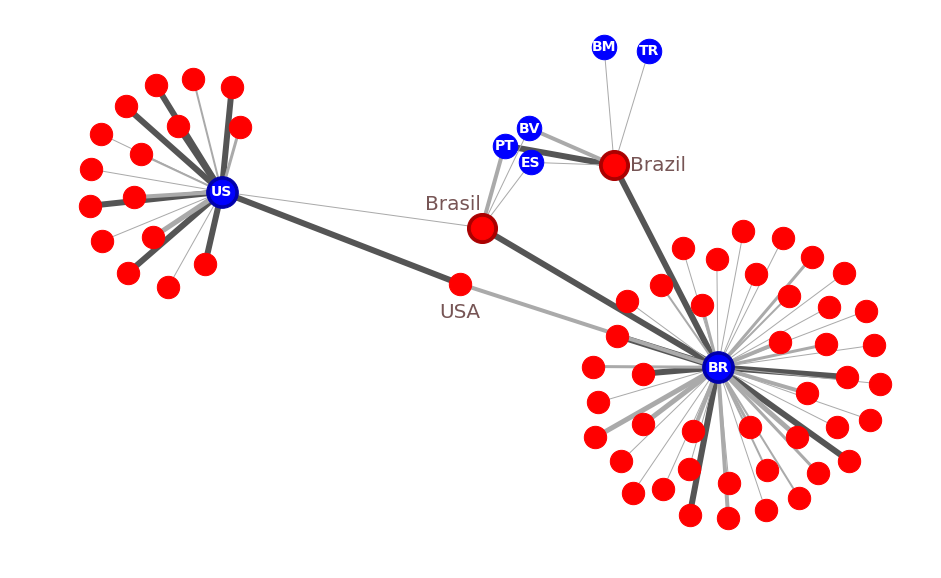

In [42]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_axis_off()

nx.draw_networkx_edges(section_graph, section_pos, ax=ax, edgelist=section_edges_big,
                       width=6, edge_color="#555555")
nx.draw_networkx_edges(section_graph, section_pos, ax=ax, edgelist=section_edges_small,
                       width=section_small_widths, edge_color="#aaaaaa")
nx.draw_networkx_nodes(section_graph, section_pos, ax=ax, nodelist=["name=Brasil", "name=Brazil"],
                       node_color="#aa0000", node_size=900)
nx.draw_networkx_nodes(section_graph, section_pos, ax=ax, nodelist=section_names,
                       node_color="red", node_size=500)
nx.draw_networkx_nodes(section_graph, section_pos, ax=ax, nodelist=["code=BR", "code=US"],
                       node_color="#0000aa", node_size=1000)
nx.draw_networkx_nodes(section_graph, section_pos, ax=ax, nodelist=section_codes,
                       node_color="blue", node_size=600)
nx.draw_networkx_labels(section_graph, section_pos, ax=ax,
                        font_size=14, font_color="white", font_weight="bold",
                        labels={code: code[5:] for code in section_codes})

section_name_deltas = {
    "Brasil": np.array([-.06, .05]), 
    "Brazil": np.array([.09, 0]),
    "USA": np.array([0, -.06]),
}
for name, delta in section_name_deltas.items():
    key = "name=" + name
    nx.draw_networkx_labels(section_graph, {key: section_pos[key] + delta}, ax=ax,
                            font_size=20, font_color="#775555",
                            labels={key: name})

fig.savefig("country/br_us_cut_graph.svg")
plt.show()

[Above image in SVG](country/br_us_cut_graph.svg)

The blue nodes are distinct country codes,
whereas the red nodes are distinct country names.
The number of occurrences relates to the color and thickness of the edges.

We're seeing this section of our data:

- The $4$ selected nodes: *Brasil*, *Brazil*, **BR** and **US**;
- Every edge connecting the selected nodes to some other node; and
- The nodes directly connected to these $4$ selected ones.

That's a graph cut, we're not seeing any other edges or nodes, but they do exist.

A country might have more than one name,
so there's no conflict on the several nodes connecting to **BR** and **US**.
That is, having dandelion-like disconnected subgraphs is okay.
Yet, some country names are connected to distinct codes.
The strongest connection (edge) of a name to a code
might be seen as the actual/real code for that name
when it's much stronger than any other connection.

This section gives us some information about the *Brasil* and *USA* nodes
having few connections with the wrong code, but also tells us that:

- Many people use the **PT** code for *Brazil*,
perhaps due to the language/locale,
given that `pt_BR` symbolizes Brazilian Portuguese;

- Some people use the **ES** code for *Brazil*,
perhaps because it's the *Espírito Santo* state code;

- There are many other names for Brazil,
several of them are typos (e.g. `Brazill`),
other are inconsistencies that the graph don't show
(i.e., some red nodes might be connected elsewhere).

A more complete undestanding of what is going on
would require an analysis beyond what had been done so far
with this graph cut/partitioning.

### The entire graph

Let's see what happens when we see the whole picture, not just a section:

In [43]:
df_non_empty = non_empty.reset_index()
df_non_empty_edge_list = pd.DataFrame({
    "name": df_non_empty["addr_country"].apply(lambda name: f"name={name}"),
    "code": df_non_empty["addr_country_code"].apply(lambda code: f"code={code}"),
    "weight": df_non_empty["count"],
})

In [44]:
non_empty_names = df_non_empty_edge_list["name"].unique().tolist()
non_empty_codes = df_non_empty_edge_list["code"].unique().tolist()

In [45]:
non_empty_graph = nx.Graph()
non_empty_graph.add_nodes_from(non_empty_names, bipartite=0)
non_empty_graph.add_nodes_from(non_empty_codes, bipartite=1)
non_empty_graph.add_weighted_edges_from(df_non_empty_edge_list.values)
nx.is_bipartite(non_empty_graph)

True

In [46]:
non_empty_pos = nx.spring_layout(non_empty_graph, k=.04, weight=None, random_state=42)
non_empty_weights = nx.get_edge_attributes(non_empty_graph, "weight")
non_empty_edges_big = [k for k, v in non_empty_weights.items() if v > 10]
non_empty_edges_small, non_empty_small_widths = \
    zip(*[(k, .5 + v / 20) for k, v in non_empty_weights.items() if v <= 10])

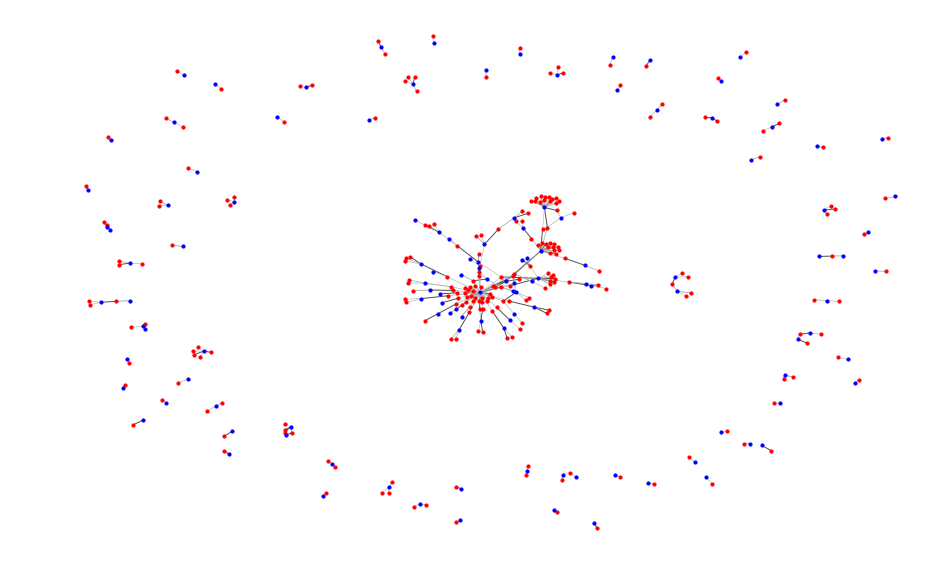

In [47]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_axis_off()

nx.draw_networkx_edges(non_empty_graph, non_empty_pos, ax=ax, edgelist=non_empty_edges_big,
                       width=1, edge_color="#555555")
nx.draw_networkx_edges(non_empty_graph, non_empty_pos, ax=ax, edgelist=non_empty_edges_small,
                       width=non_empty_small_widths, edge_color="#aaaaaa")
nx.draw_networkx_nodes(non_empty_graph, non_empty_pos, ax=ax, nodelist=non_empty_names,
                       node_color="red", node_size=10)
nx.draw_networkx_nodes(non_empty_graph, non_empty_pos, ax=ax, nodelist=non_empty_codes,
                       node_color="blue", node_size=10)

fig.savefig("country/non_empty_graph.svg")
plt.show()

[Above image in SVG](country/non_empty_graph.svg)

What can be said about that?
Several names have a single matching code,
but there are some inconsistency subgraphs.
The worst part to understand seem to be the central subgraph
with several codes and names somewhat tied together.

At first: how many connected subgraphs with more than one country code does the above graph have?

In [48]:
subgraphs = [graph for graph in nx.connected_component_subgraphs(non_empty_graph)
                   if len(graph.nodes) > 2
                   and sum(node_name.startswith("code=") for node_name in graph.nodes) > 1]
len(subgraphs)

7

How many nodes and edges each subgraph has?

In [49]:
[len(graph.nodes) for graph in subgraphs]

[167, 6, 4, 5, 7, 3, 5]

In [50]:
[len(graph.edges) for graph in subgraphs]

[182, 7, 3, 4, 6, 2, 4]

We can plot the 6 smaller ones at once:

In [51]:
import matplotlib.patches as mpatches

In [52]:
class CustomLegendHandler(object):

    def __init__(self, fontsize):
        self.fontsize = fontsize

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        radius = min(width, height) * .9
        xc = x0 + handlebox.width / 2
        yc = y0 + handlebox.height / 2
        patch = mpatches.Circle([xc, yc], radius, color="r")
        text = plt.Text(xc, yc, str(orig_handle), color="w",
                        ha="center", va="center",
                        fontweight="bold", fontsize=self.fontsize)
        handlebox.add_artist(patch)
        handlebox.add_artist(text)

In [53]:
all_subgraph_g_names = [k for graph in subgraphs[1:]
                          for k, v in graph.nodes.items()
                          if v["bipartite"] == 0]
legend_numbers = {name: idx for idx, name
                            in enumerate(all_subgraph_g_names, 1)}

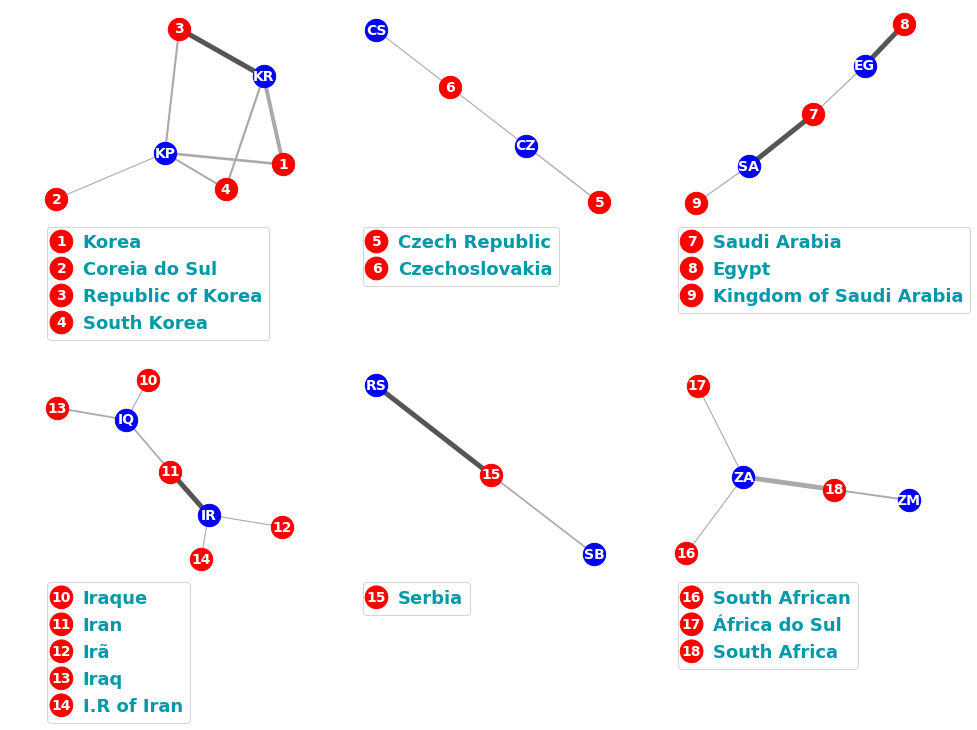

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))
for graph, ax in zip(subgraphs[1:], axes.flat):
    ax_box = ax.get_position()
    ax.set_axis_off()
    ax.set_position([ax_box.x0, ax_box.y0, ax_box.width, ax_box.height * .7])

    g_names = [k for k, v in graph.nodes.items() if v["bipartite"] == 0]
    g_codes = [k for k, v in graph.nodes.items() if v["bipartite"] == 1]
    g_numbers = [legend_numbers[name] for name in g_names]

    g_pos = nx.spring_layout(graph, k=.03, weight=None, random_state=42)
    g_weights = nx.get_edge_attributes(graph, "weight")
    g_edges_big = [k for k, v in g_weights.items() if v > 40]
    g_edges_small, g_small_widths = zip(*[(k, 1 + v / 10) for k, v in g_weights.items() if v <= 40])

    nx.draw_networkx_edges(graph, g_pos, ax=ax, edgelist=g_edges_big,
                           width=5, edge_color="#555555")
    nx.draw_networkx_edges(graph, g_pos, ax=ax, edgelist=g_edges_small,
                           width=g_small_widths, edge_color="#aaaaaa")
    nx.draw_networkx_nodes(graph, g_pos, ax=ax, nodelist=g_names,
                           node_color="red", node_size=500)
    nx.draw_networkx_nodes(graph, g_pos, ax=ax, nodelist=g_codes,
                           node_color="blue", node_size=500)
    nx.draw_networkx_labels(graph, g_pos, ax=ax,
                            font_size=14, font_color="white", font_weight="bold",
                            labels={code: code[5:] for code in g_codes})
    nx.draw_networkx_labels(graph, g_pos, ax=ax,
                            font_size=14, font_color="white", font_weight="bold",
                            labels=dict(zip(g_names, g_numbers)))

    legends = ax.legend(
        loc="upper left",
        bbox_to_anchor=(0, 0),
        handles=g_numbers,
        labels=[name[5:] for name in g_names],
        fontsize=18,
        handlelength=.75,
        handler_map={int: CustomLegendHandler(fontsize=14)},
    )
    for legend_text in legends.get_texts():
        legend_text.set(color="#0099aa", weight="bold")

fig.savefig("country/small_6_subgraphs.svg")
plt.show()

[Above image in SVG](country/small_6_subgraphs.svg)

These aren't graph cuts but subgraphs as connecte as they are in the original graph.
Each of them have $2$ distinct country codes:

- **KR** stands for *Republic of Korea* (a.k.a. *South Korea*),
whereas **KP** stands for *Democratic People's Republic of Korea* (a.k.a. *North Korea*).
Though `1` is the only name of this subgraph with a single code in the dataset, it's inconsistent.
`2` is ambiguous, but `1`, `3` and `4` should always have been connected to **KR**;

- **CZ** stands for *Czech Republic*, but **CS**
[has its own history](https://en.wikipedia.org/wiki/ISO_3166-2:CS),
which makes it difficult to understand what's going on.
Perhaps the **CS** entries should have been **CZ** or **SK** (*Slovakia*),
but we can't be sure we're not talking about the former *Yugoslavia*.
A summary of the **CS** code history is:

  - **CS** standed for *Czechoslovakia* in the former ISO 3166-1 standard;
  - 1993: *Czechoslovakia* was dissolved;
  - 1998: The first publication of ISO 3166-2 (no **CS** entry);
  - 2003: **YU** (*Yugoslavia*) was renamed to **CS** (*Serbia and Montenegro*);
  - 2006: *Serbia and Montenegro* was dissolved;
  - 2007: **CS** was deleted from the standard.

- Most *Egypt* and *Saudi Arabia* entries are consistently connected,
but there are some *Saudi Arabia* connected with **EG**.
Likewise, *Iran* and *Iraq* entries are mostly consistently connected,
but there are a few *Iran* connected to **IQ**.
These inconsistencies have to be fixed,
but for these name nodes we can keep only the strongest edge to find its code,
cutting the remaining as inconsistencies;

- **SB** stands for *Solomon Islands*, not *Serbia* (**RS**);

- **ZM** stands for *Zambia*, not *South Africa* (**ZA**).

From the many-connections \[central] subgraph, it's pretty hard to grasp something:

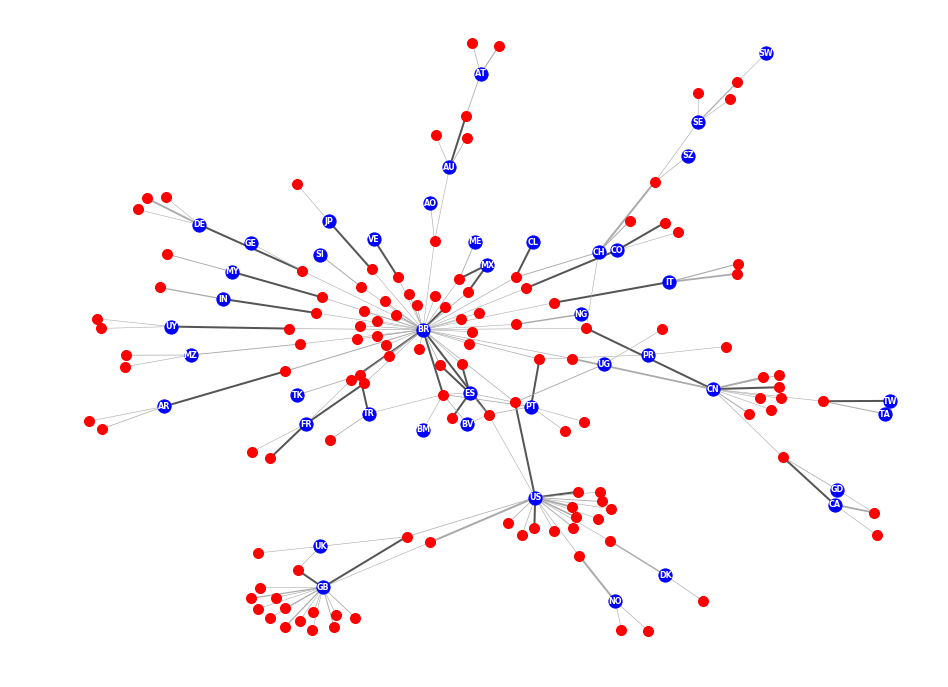

In [55]:
g0 = subgraphs[0]
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()

g0_names = [k for k, v in g0.nodes.items() if v["bipartite"] == 0]
g0_codes = [k for k, v in g0.nodes.items() if v["bipartite"] == 1]

g0_pos = nx.spring_layout(g0, k=.025, weight=None, random_state=43)
g0_weights = nx.get_edge_attributes(g0, "weight")
g0_edges_big = [k for k, v in g0_weights.items() if v > 30]
g0_edges_small, g0_small_widths = zip(*[(k, .5 + v / 20) for k, v in g0_weights.items() if v <= 30])

nx.draw_networkx_edges(g0, g0_pos, ax=ax, edgelist=g0_edges_big,
                       width=2, edge_color="#555555")
nx.draw_networkx_edges(g0, g0_pos, ax=ax, edgelist=g0_edges_small,
                       width=g0_small_widths, edge_color="#aaaaaa")
nx.draw_networkx_nodes(g0, g0_pos, ax=ax, nodelist=g0_names,
                       node_color="red", node_size=100)
nx.draw_networkx_nodes(g0, g0_pos, ax=ax, nodelist=g0_codes,
                       node_color="blue", node_size=175)
nx.draw_networkx_labels(g0, g0_pos, ax=ax,
                        font_size=8, font_color="white", font_weight="bold",
                        labels={code: code[5:] for code in g0_codes})

fig.savefig("country/big_subgraph.svg")
plt.show()

[Above image in SVG](country/big_subgraph.svg)

It's still confusing! At least, several names have a single code,
and some names have a weight gap with a single stronger connection to a code.
Nevertheless, that shows us where most inconsistencies lies.

There are codes like **UK** that should have been **GB**, as it's the code for
*United Kingdom of Great Britain and Northern Ireland*.
It's both a country and a country made up of countries,
but *England*, *Scotland*, *Wales*, and *Northern Ireland*
don't have their own ISO-3166 alpha-2 code.
The normalization might be undesirable
if we lose the specific country information
regarding which of the $4$ the affiliation is from.

Let's see the above graph without the country names that have only a single connection.

In [56]:
single_connected_names = \
    [node for node, degree in nx.degree(g0)
          if degree == 1 and node.startswith("name=")]

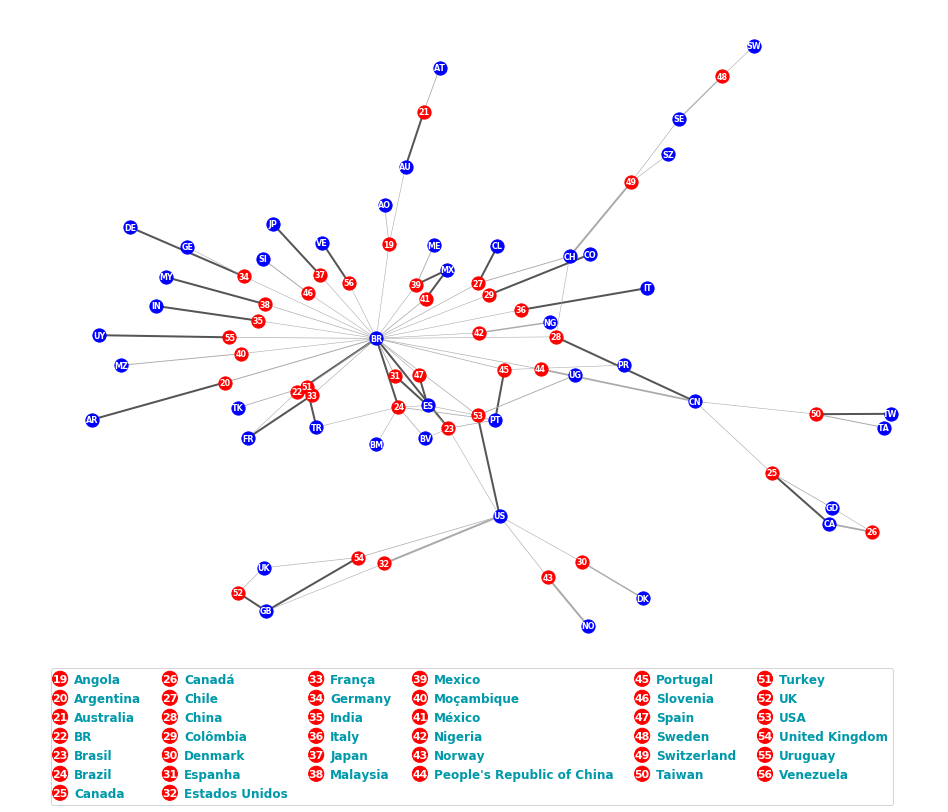

In [57]:
g0t = g0.copy()
g0t.remove_nodes_from(single_connected_names)

fig, ax = plt.subplots(figsize=(16, 15))
ax_box = ax.get_position()
ax.set_axis_off()
ax.set_position([ax_box.x0, ax_box.y0, ax_box.width, ax_box.height * .8])

g0t_names = sorted(k for k, v in g0t.nodes.items() if v["bipartite"] == 0)
g0t_first_number = len(legend_numbers) + 1
g0t_numbers = range(g0t_first_number, g0t_first_number + len(g0t_names))

g0t_weights = nx.get_edge_attributes(g0t, "weight")
g0t_edges_big = [k for k, v in g0t_weights.items() if v > 30]
g0t_edges_small, g0t_small_widths = zip(*[(k, .5 + v / 20) for k, v in g0t_weights.items() if v <= 30])

nx.draw_networkx_edges(g0t, g0_pos, ax=ax, edgelist=g0t_edges_big,
                       width=2, edge_color="#555555")
nx.draw_networkx_edges(g0t, g0_pos, ax=ax, edgelist=g0t_edges_small,
                       width=g0t_small_widths, edge_color="#aaaaaa")
nx.draw_networkx_nodes(g0t, g0_pos, ax=ax, nodelist=g0t_names,
                       node_color="red", node_size=175)
nx.draw_networkx_nodes(g0t, g0_pos, ax=ax, nodelist=g0_codes,
                       node_color="blue", node_size=175)
nx.draw_networkx_labels(g0t, g0_pos, ax=ax,
                        font_size=8, font_color="white", font_weight="bold",
                        labels={code: code[5:] for code in g0_codes})
nx.draw_networkx_labels(g0t, g0_pos, ax=ax,
                        font_size=8, font_color="white", font_weight="bold",
                        labels=dict(zip(g0t_names, g0t_numbers)))

legends = ax.legend(
    loc="upper left",
    bbox_to_anchor=(0, 0),
    handles=g0t_numbers,
    labels=[name[5:] for name in g0t_names],
    fontsize=12,
    ncol=6,
    handlelength=.75,
    handler_map={int: CustomLegendHandler(fontsize=11)},
)
for legend_text in legends.get_texts():
    legend_text.set(color="#0099aa", weight="bold")

fig.savefig("country/big_subgraph_without_singles.svg")
plt.show()

[Above image in SVG](country/big_subgraph_without_singles.svg)

Unless some single-code subgraph is missing the correct code for a given name,
there's no inconsistency within the country pair
beyond what had been shown in this last image.
That graph still has edges consistent with ISO-3166,
but at least half of the edges are inconsistencies
that a simple fuzzy matching normalization wouldn't help.
Most country names seem correctly written,
yet the code isn't the same in every entry,
so we can either:

- Overwrite the code with the one that matches the name;
- Overwrite the name with the one that matches the code;
- Delete both name and code as they're inconsistent;
- Find something else to know in which information we should trust.

Keeping the inconsistency isn't an option now that we know where they are.
At first, we should at least delete both to avoid mistakes.

*How about the entries missing the code or the name?*

If there's just a name or a code missing (but not both), they're the easiest ones:
we can always use the strongest edge connected to the given node.

A custom enforced code-name mapping from otherwhere
can be modeled as a stronger edge in the graph,
but there might be no need to do so:
once we have the normalized code we can just apply the mapping,
and the mapping doesn't need to include
every possible writing of the country name.
Nevertheless, the stronger edge would help
on avoiding the single-code subgraph missing problem.

If the name entry doesn't exist in the graph,
we can stick with the nearest name,
using the fuzzy/Levenshtein approach.

*How about the $2829$ entries missing both code and name?*

We should find something else.
Every pair of columns can be used to create bipartite graphs.